In [3]:
# Markov Chain Monte Carlo Maximum Likelihood Estimation
# Bayesian Model Comparison
# TODO: This is Metropolis algorithm. Rewrite for non-symmetric case (= Metropolis-Hastings) with bounds.
# Currently, bounds imposed by sigmoid regularization of the optimised variables

using HDF5, EzXML, Glob, Dates, Plots, Optim, Symbolics, JuMP, StatsBase, DataFrames, CSV, Random, Distributions
using CurveFit
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")

datapath = "/Users/jjc/CSF/Recordings/"
path = pwd();
savepath = "/Users/jjc/CSF/"
files = glob("*.hdf5", datapath);

global df = DataFrame(filename=files, Rcsf=NaN, E=NaN, Ib=NaN, P0=NaN, mode=NaN, error=NaN, R2=NaN, Pss=NaN, Rcsf_std=NaN, E_std=NaN, P0_std=NaN, Ib_std=NaN)

# for j = eachindex(files)
# for j  = 1:1000
# 990 good, 1141 good, 200 good
for j = 1:length(files)

    j in [278, 442, 521, 621, 676, 708, 755, 989, 1010, 1041, 1042, 1043] ? (continue) : 0 # Some recordings do not have summaries data saved

    filename = files[j]
    # filename = "/Users/jjc/Documents/SSC/recs_june_2022/inf_20120717114717_INF2.hdf5"

    global Data = readCSF(filename)

    length(Data["ICP"]) > Data["infusion_end_frame"] ? (global Pm = Data["ICP"][Data["infusion_start_frame"]:Data["infusion_end_frame"]]) : (global Pm = Data["ICP"][Data["infusion_start_frame"]:end])
    global tslength = minimum([Data["infusion_end_frame"], length(Data["ICP"])])

    D = Pm # Data

    global lb = [0.01, 0.01, -10.0, 0.1]
    global ub = [50.0, 1.0, Data["P_b"], 0.9]
    Ib_lower = lb[4]
    Ib_upper = ub[4]

    θ₁ = zeros(3)
    y = solvemodelPss(θ₁...)
    y = y[Data["infusion_start_frame"]:end]

    σ = 1.0 # standard deviation for the model 
    χ₁ = sum((D .- y) .^ 2) / (2 * σ^2) #

    total_n = 50000 # Number of iterations
    burntime = 10000 # Burn time

    # total_n = 1000000 # Number of iterations
    # burntime = 100000 # Burn time
    # a = [10.35, 0.14, 10.54] # Guess standard deviation
    # a = zeros(3) .+ 0.1 # Guess standard deviation for the parameters
    a = zeros(3) .+ 0.1 # Guess standard deviation for the parameters = how wide around the current guess we want to deviate [0.01 good], higher = exploration, lower = exploitation
    # TODO: consider adding a different one to the I_b convergence to bounds

    global thetasave = zeros(3, total_n - burntime)
    global thetasave_t = zeros(3, total_n - burntime)
    global chisave = zeros(total_n - burntime)

    for i = 1:total_n

        θ₂ = θ₁ .+ a .* randn(3) # Normal distribution

        Rcsf = sigmoid(θ₁[1], lb[1], ub[1])
        E = sigmoid(θ₁[2], lb[2], ub[2])
        Pss = sigmoid(θ₁[3], lb[3], ub[3])
        I_b = (Data["P_b"] - Pss) / Rcsf

        while (I_b < lb[4]) || (I_b > ub[4])
            θ₂ = θ₁ .+ a .* randn(3) # Normal distribution
            Rcsf = sigmoid(θ₂[1], lb[1], ub[1])
            E = sigmoid(θ₂[2], lb[2], ub[2])
            Pss = sigmoid(θ₂[3], lb[3], ub[3])
            I_b = (Data["P_b"] - Pss) / Rcsf
        end

        y = solvemodelPss(θ₂...)
        y = y[Data["infusion_start_frame"]:end]
        χ₂ = sum((D .- y) .^ 2) / (2 * σ^2)

        ratio = exp((-χ₂ + χ₁) / 2 * σ^2) # Likelihood ratio
        r = rand(1)[1] # Uniform distribution

        if r < ratio
            θ₁ = θ₂
            χ₁ = χ₂
        end

        ths = zeros(3)
        if i > burntime
            ths[1] = sigmoid(θ₁[1], lb[1], ub[1])
            ths[2] = sigmoid(θ₁[2], lb[2], ub[2])
            ths[3] = sigmoid(θ₁[3], lb[3], ub[3])
            thetasave[:, i-burntime] = θ₁
            thetasave_t[:, i-burntime] .= ths
            chisave[i-burntime] = χ₁
        end
    end

    # thetasave_t = thetasave

    Ib_all = zeros(total_n - burntime)
    global Ib_all .= (Data["P_b"] .- thetasave_t[3, :]) ./ thetasave_t[1, :]
    # global Ib_all .= (Data["P_b"] .- Data["Pss"]) ./ thetasave_t[1, :]

    # println("Rcsf = $(round(mean(thetasave_t[1,:]),digits=2)) ± $(round(std(thetasave_t[1,:]),digits=2))")
    # println("I_b = $(round(mean(Ib_all),digits=2)) ± $(round(std(Ib_all),digits=2))")
    # println("E = $(round(mean(thetasave_t[2,:]),digits=2)) ± $(round(std(thetasave_t[2,:]),digits=2))")
    # println("Pss = $(round(mean(thetasave_t[3,:]),digits=2)) ± $(round(std(thetasave_t[3,:]),digits=2))")

    println("Rcsf = $(round(median(thetasave_t[1,:]),digits=2)) ± $(round(std(thetasave_t[1,:]),digits=2))")
    println("I_b = $(round(median(Ib_all),digits=2)) ± $(round(std(Ib_all),digits=2))")
    println("E = $(round(median(thetasave_t[2,:]),digits=2)) ± $(round(std(thetasave_t[2,:]),digits=2))")
    println("Pss = $(round(median(thetasave_t[3,:]),digits=2)) ± $(round(std(thetasave_t[3,:]),digits=2))")
    println("P_0 = $(round(Data["P_0"]))")

    opt_idx = findmin(chisave)[2]
    Rcsf = sigmoid(thetasave[1, opt_idx], lb[1], ub[1])
    E = sigmoid(thetasave[2, opt_idx], lb[2], ub[2])
    Pss = sigmoid(thetasave[3, opt_idx], lb[3], ub[3])
    I_b = (Data["P_b"] - Pss) / Rcsf

    df.Rcsf[j] = (round(mean(thetasave_t[1, :]), digits=2))
    df.P0[j] = (round(mean(thetasave_t[3, :]), digits=2))
    df.Ib[j] = (round(mean(Ib_all), digits=2))
    df.E[j] = (round(mean(thetasave_t[2, :]), digits=2))
    df.filename[j] = filename[length(datapath)+2:end]
    df.error[j] = round(calc_model_plot(I_b, E, Pss)[2], digits=3)
    # global Pm = solvemodel(Rcsf, E, Pss)
    length(Data["ICP"]) > Data["infusion_end_frame"] ? (global Pm = Data["ICP"][Data["infusion_start_frame"]:Data["infusion_end_frame"]]) : (global Pm = Data["ICP"][Data["infusion_start_frame"]:end])
    global tslength = minimum([Data["infusion_end_frame"], length(Data["ICP"])])
    volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(Rcsf, Pss)
    df.R2[j] = round(R2, digits=3)
    df.Rcsf_std[j] = (round(std(thetasave_t[1, :]), digits=2))
    df.E_std[j] = (round(std(thetasave_t[2, :]), digits=2))
    df.P0_std[j] = (round(std(thetasave_t[3, :]), digits=2))
    df.Ib_std[j] = (round(std(Ib_all), digits=2))
    println("File $j / $(length(files))")
    CSV.write("/Users/jjc/CSF/Results/Results_BayesPss.csv", df)
end
# CSV.write("/Users/jjc/CSF/Results/Results_BayesSTD.csv", df)
μ = mean(thetasave_t, dims=2)
σ = std(thetasave_t, dims=2)

# Rcsf = sigmoid(mean(thetasave[1,:]), lb[1], ub[1])
# E = sigmoid(mean(thetasave[2,:]), lb[2], ub[2])
# Pss = sigmoid(mean(thetasave[3,:]), lb[3], ub[3])
# I_b = (Data["P_b"] - Pss) / Rcsf

opt_idx = findmin(chisave)[2]
Rcsf = sigmoid(thetasave[1, opt_idx], lb[1], ub[1])
E = sigmoid(thetasave[2, opt_idx], lb[2], ub[2])
Pss = sigmoid(thetasave[3, opt_idx], lb[3], ub[3])
I_b = Ib_all[opt_idx]

rmserr = calc_model_plot(I_b, E, Data["P_0"], Pss)[2]
h0 = plotmodel(I_b, E, Data["P_0"], Pss, μ, σ, "dar", "")
title!("I_b = $(round(I_b,digits=2)) ± $(round(std(Ib_all),digits=3)) [mL/min]\n" * "Rcsf = $(round(value(Rcsf),digits=2)) ± $(round(std(thetasave_t[1,:]),digits=2)) [mmHg/(ml/min)]\n" * "E = $(round(value(E),digits=2)) ± $(round(std(thetasave_t[2,:]),digits=2)) [1/mL]\n" * "Pss = $(round(value(Pss),digits=2)) ± $(round(std(thetasave_t[3,:]),digits=2)) [mmHg]\n" * "error = $rmserr", titlealign=:left, titlefontsize=8, xlabel="Time [min]", ylabel="ICP [mmHg]")

# icmp_curve = calc_model_plot((Data["P_b"]-Data["Pss"])/Data["Rcsf"], Data["E"], Data["Pss"])[1]
# plot!(icmp_curve, lw=2, alpha=0.7, label="∇ descent")

Rcsf = 10.59 ± 0.19
I_b = 0.1 ± 0.01
E = 0.77 ± 0.05
Pss = 18.03 ± 0.11
P_0 = 18.0
File 1 / 1141
Rcsf = 24.67 ± 1.58
I_b = 0.67 ± 0.04
E = 0.11 ± 0.01
Pss = -4.02 ± 0.47
P_0 = -4.0
File 2 / 1141
Rcsf = 10.05 ± 0.1
I_b = 1.05 ± 0.02
E = 0.7 ± 0.03
Pss = 1.24 ± 0.12
P_0 = -5.0
File 3 / 1141
Rcsf = 11.32 ± 0.69
I_b = 0.99 ± 0.05
E = 0.05 ± 0.01
Pss = -5.78 ± 0.35
P_0 = -5.0
File 4 / 1141
Rcsf = 9.38 ± 0.39
I_b = 0.28 ± 0.04
E = 0.24 ± 0.04
Pss = 10.63 ± 0.32
P_0 = 10.0
File 5 / 1141
Rcsf = 13.68 ± 0.18
I_b = 0.15 ± 0.02
E = 0.37 ± 0.02
Pss = 7.15 ± 0.24
P_0 = 7.0
File 6 / 1141
Rcsf = 19.58 ± 0.26
I_b = 0.56 ± 0.02
E = 0.1 ± 0.0
Pss = -7.22 ± 0.3
P_0 = -5.0
File 7 / 1141
Rcsf = 22.69 ± 0.45
I_b = 0.18 ± 0.01
E = 0.38 ± 0.03
Pss = 8.37 ± 0.31
P_0 = 7.0
File 8 / 1141
Rcsf = 23.0 ± 0.72
I_b = 0.72 ± 0.02
E = 0.09 ± 0.0
Pss = -6.16 ± 0.38
P_0 = -5.0
File 9 / 1141
Rcsf = 15.01 ± 0.0
I_b = 0.94 ± 0.0
E = 0.1 ± 0.0
Pss = -2.6 ± 0.0
P_0 = -5.0
File 10 / 1141
Rcsf = 18.27 ± 0.2
I_b = 0.22 ± 0.02
E 

File 102 / 1141
Rcsf = 17.74 ± 0.36
I_b = 0.31 ± 0.03
E = 0.32 ± 0.02
Pss = 8.5 ± 0.37
P_0 = 7.0
File 103 / 1141
Rcsf = 15.79 ± 0.25
I_b = 0.21 ± 0.02
E = 0.19 ± 0.01
Pss = 8.89 ± 0.23
P_0 = 9.0
File 104 / 1141
Rcsf = 13.38 ± 0.37
I_b = 0.59 ± 0.04
E = 0.18 ± 0.02
Pss = 5.98 ± 0.37
P_0 = 6.0
File 105 / 1141
Rcsf = 22.39 ± 0.83
I_b = 0.12 ± 0.01
E = 0.32 ± 0.02
Pss = 7.87 ± 0.26
P_0 = 8.0
File 106 / 1141
Rcsf = 17.94 ± 0.21
I_b = 0.15 ± 0.01
E = 0.16 ± 0.01
Pss = 7.54 ± 0.19
P_0 = 7.0
File 107 / 1141
Rcsf = 10.78 ± 0.37
I_b = 0.54 ± 0.03
E = 0.07 ± 0.01
Pss = 9.63 ± 0.27
P_0 = 9.0
File 108 / 1141
Rcsf = 15.81 ± 0.22
I_b = 0.14 ± 0.02
E = 0.37 ± 0.02
Pss = 8.05 ± 0.24
P_0 = 7.0
File 109 / 1141
Rcsf = 18.66 ± 0.45
I_b = 0.09 ± 0.01
E = 0.4 ± 0.02
Pss = 5.96 ± 0.14
P_0 = 5.0
File 110 / 1141
Rcsf = 49.98 ± 0.98
I_b = 0.12 ± 0.01
E = 0.13 ± 0.0
Pss = 16.21 ± 0.22
P_0 = 16.0
File 111 / 1141
Rcsf = 9.42 ± 0.25
I_b = 0.59 ± 0.05
E = 0.17 ± 0.02
Pss = 5.69 ± 0.39
P_0 = 5.0
File 112 / 1141
Rcsf =

Rcsf = 23.29 ± 5.1
I_b = 0.11 ± 0.02
E = 0.27 ± 0.03
Pss = 13.24 ± 0.34
P_0 = 13.0
File 204 / 1141
Rcsf = 10.66 ± 0.2
I_b = 0.28 ± 0.03
E = 0.22 ± 0.01
Pss = 4.9 ± 0.27
P_0 = 4.0
File 205 / 1141
Rcsf = 13.36 ± 0.19
I_b = 0.11 ± 0.01
E = 0.38 ± 0.02
Pss = 7.06 ± 0.16
P_0 = 5.0
File 206 / 1141
Rcsf = 17.4 ± 0.0
I_b = 1.02 ± 0.0
E = 0.37 ± 0.0
Pss = 3.08 ± 0.0
P_0 = -5.0
File 207 / 1141
Rcsf = 49.58 ± 0.56
I_b = 0.22 ± 0.01
E = 0.11 ± 0.0
Pss = -2.46 ± 0.24
P_0 = -3.0
File 208 / 1141
Rcsf = 10.73 ± 0.33
I_b = 0.68 ± 0.06
E = 0.22 ± 0.02
Pss = -0.34 ± 0.45
P_0 = -3.0
File 209 / 1141
Rcsf = 15.74 ± 0.43
I_b = 0.25 ± 0.02
E = 0.14 ± 0.01
Pss = 3.49 ± 0.25
P_0 = 4.0
File 210 / 1141
Rcsf = 36.97 ± 0.0
I_b = 0.09 ± 0.0
E = 0.28 ± 0.0
Pss = 17.35 ± 0.0
P_0 = 20.0
File 211 / 1141
Rcsf = 13.84 ± 0.3
I_b = 0.24 ± 0.02
E = 0.23 ± 0.02
Pss = 8.77 ± 0.3
P_0 = 8.0
File 212 / 1141
Rcsf = 37.67 ± 7.47
I_b = 0.59 ± 0.13
E = 0.02 ± 0.0
Pss = -5.89 ± 0.28
P_0 = -5.0
File 213 / 1141
Rcsf = 39.13 ± 1.18
I_b =

P_0 = -5.0
File 305 / 1141
Rcsf = 9.59 ± 0.08
I_b = 0.99 ± 0.03
E = 0.33 ± 0.01
Pss = 3.47 ± 0.16
P_0 = -0.0
File 306 / 1141
Rcsf = 9.35 ± 0.35
I_b = 0.26 ± 0.03
E = 0.2 ± 0.02
Pss = 5.63 ± 0.28
P_0 = 5.0
File 307 / 1141
Rcsf = 10.88 ± 0.16
I_b = 0.08 ± 0.01
E = 0.33 ± 0.01
Pss = 3.53 ± 0.08
P_0 = 3.0
File 308 / 1141
Rcsf = 12.68 ± 0.22
I_b = 0.43 ± 0.03
E = 0.14 ± 0.01
Pss = 6.04 ± 0.29
P_0 = 6.0
File 309 / 1141
Rcsf = 14.38 ± 0.28
I_b = 0.32 ± 0.03
E = 0.34 ± 0.03
Pss = 4.4 ± 0.38
P_0 = 2.0
File 310 / 1141
Rcsf = 23.46 ± 0.46
I_b = 0.17 ± 0.02
E = 0.44 ± 0.03
Pss = 9.64 ± 0.34
P_0 = 8.0
File 311 / 1141
Rcsf = 6.44 ± 3.16
I_b = 0.6 ± 0.13
E = 0.22 ± 0.07
Pss = 4.74 ± 0.59
P_0 = 4.0
File 312 / 1141
Rcsf = 10.88 ± 0.33
I_b = 0.97 ± 0.04
E = 0.12 ± 0.0
Pss = -2.59 ± 0.15
P_0 = -5.0
File 313 / 1141
Rcsf = 7.76 ± 0.31
I_b = 0.41 ± 0.07
E = 0.42 ± 0.06
Pss = 7.56 ± 0.45
P_0 = 6.0
File 314 / 1141
Rcsf = 10.8 ± 0.12
I_b = 0.08 ± 0.0
E = 0.15 ± 0.0
Pss = 6.39 ± 0.03
P_0 = 7.0
File 315 / 1141
R

Pss = 3.31 ± 0.38
P_0 = 3.0
File 406 / 1141
Rcsf = 17.39 ± 1.14
I_b = 0.97 ± 0.05
E = 0.09 ± 0.01
Pss = -6.72 ± 0.57
P_0 = -5.0
File 407 / 1141
Rcsf = 19.45 ± 1.5
I_b = 0.87 ± 0.05
E = 0.08 ± 0.01
Pss = -5.69 ± 0.48
P_0 = -5.0
File 408 / 1141
Rcsf = 3.49 ± 0.0
I_b = 1.16 ± 0.0
E = 0.66 ± 0.0
Pss = 7.98 ± 0.0
P_0 = 10.0
File 409 / 1141
Rcsf = 11.51 ± 0.58
I_b = 0.24 ± 0.03
E = 0.33 ± 0.05
Pss = 14.05 ± 0.38
P_0 = 14.0
File 410 / 1141
Rcsf = 16.28 ± 0.0
I_b = 0.94 ± 0.0
E = 0.08 ± 0.0
Pss = -1.84 ± 0.0
P_0 = -5.0
File 411 / 1141
Rcsf = 8.11 ± 0.24
I_b = 0.41 ± 0.05
E = 0.22 ± 0.03
Pss = 8.96 ± 0.35
P_0 = 9.0
File 412 / 1141
Rcsf = 11.73 ± 0.31
I_b = 0.37 ± 0.03
E = 0.19 ± 0.02
Pss = 10.78 ± 0.29
P_0 = 11.0
File 413 / 1141
Rcsf = 14.79 ± 0.32
I_b = 0.95 ± 0.03
E = 0.1 ± 0.01
Pss = -5.85 ± 0.43
P_0 = -5.0
File 414 / 1141
Rcsf = 15.78 ± 0.36
I_b = 0.27 ± 0.03
E = 0.32 ± 0.03
Pss = 11.06 ± 0.33
P_0 = 11.0
File 415 / 1141
Rcsf = 14.53 ± 0.23
I_b = 0.3 ± 0.03
E = 0.3 ± 0.02
Pss = 4.31 ± 0.34
P

P_0 = -5.0
File 508 / 1141
Rcsf = 48.15 ± 6.69
I_b = 0.43 ± 0.1
E = 0.02 ± 0.0
Pss = -8.9 ± 0.22
P_0 = -5.0
File 509 / 1141
Rcsf = 9.75 ± 0.12
I_b = 1.04 ± 0.03
E = 0.47 ± 0.02
Pss = 0.49 ± 0.21
P_0 = -5.0
File 510 / 1141
Rcsf = 30.64 ± 2.53
I_b = 0.78 ± 0.05
E = 0.11 ± 0.01
Pss = -6.43 ± 0.52
P_0 = -5.0
File 511 / 1141
Rcsf = 19.78 ± 0.07
I_b = 0.95 ± 0.01
E = 0.17 ± 0.0
Pss = -1.06 ± 0.07
P_0 = -5.0
File 512 / 1141
Rcsf = 32.66 ± 2.4
I_b = 0.09 ± 0.01
E = 0.26 ± 0.01
Pss = 8.96 ± 0.23
P_0 = 9.0
File 513 / 1141
Rcsf = 10.02 ± 0.4
I_b = 0.2 ± 0.05
E = 0.62 ± 0.1
Pss = 18.68 ± 0.4
P_0 = 19.0
File 514 / 1141
Rcsf = 21.32 ± 0.38
I_b = 0.25 ± 0.02
E = 0.25 ± 0.01
Pss = 6.68 ± 0.33
P_0 = 5.0
File 515 / 1141
Rcsf = 49.96 ± 0.21
I_b = 0.2 ± 0.0
E = 0.05 ± 0.0
Pss = 1.9 ± 0.19
P_0 = 5.0
File 516 / 1141
Rcsf = 16.35 ± 0.1
I_b = 0.08 ± 0.0
E = 0.35 ± 0.01
Pss = 9.75 ± 0.06
P_0 = 9.0
File 517 / 1141
Rcsf = 15.61 ± 0.43
I_b = 0.36 ± 0.03
E = 0.21 ± 0.02
Pss = 8.06 ± 0.35
P_0 = 8.0
File 518 / 1141


E = 0.12 ± 0.01
Pss = 1.01 ± 0.42
P_0 = 1.0
File 610 / 1141
Rcsf = 8.59 ± 0.12
I_b = 0.09 ± 0.01
E = 0.49 ± 0.02
Pss = 7.25 ± 0.1
P_0 = 7.0
File 611 / 1141
Rcsf = 17.83 ± 0.31
I_b = 0.27 ± 0.02
E = 0.17 ± 0.01
Pss = 2.22 ± 0.26
P_0 = 2.0
File 612 / 1141
Rcsf = 12.39 ± 0.47
I_b = 0.45 ± 0.02
E = 0.07 ± 0.0
Pss = 4.09 ± 0.25
P_0 = 4.0
File 613 / 1141
Rcsf = 10.45 ± 0.25
I_b = 0.88 ± 0.05
E = 0.16 ± 0.01
Pss = -5.27 ± 0.34
P_0 = -5.0
File 614 / 1141
Rcsf = 10.52 ± 0.0
I_b = 1.02 ± 0.0
E = 0.43 ± 0.0
Pss = 3.15 ± 0.0
P_0 = -5.0
File 615 / 1141
Rcsf = 8.21 ± 0.27
I_b = 0.81 ± 0.07
E = 0.22 ± 0.02
Pss = 4.72 ± 0.4
P_0 = 4.0
File 616 / 1141
Rcsf = 23.07 ± 0.41
I_b = 0.82 ± 0.03
E = 0.1 ± 0.01
Pss = -6.28 ± 0.36
P_0 = -5.0
File 617 / 1141
Rcsf = 21.07 ± 0.84
I_b = 0.11 ± 0.01
E = 0.16 ± 0.01
Pss = 9.61 ± 0.17
P_0 = 10.0
File 618 / 1141
Rcsf = 11.61 ± 0.26
I_b = 0.12 ± 0.01
E = 0.2 ± 0.01
Pss = 5.19 ± 0.15
P_0 = 7.0
File 619 / 1141
Rcsf = 3.81 ± 3.0
I_b = 0.76 ± 0.15
E = 0.06 ± 0.02
Pss = -1.66

E = 0.15 ± 0.02
Pss = 5.65 ± 0.37
P_0 = 5.0
File 714 / 1141
Rcsf = 2.39 ± 1.66
I_b = 0.41 ± 0.24
E = 1.0 ± 0.2
Pss = 4.52 ± 0.36
P_0 = 3.0
File 715 / 1141
Rcsf = 10.14 ± 0.42
I_b = 0.32 ± 0.05
E = 0.32 ± 0.05
Pss = 11.03 ± 0.39
P_0 = 10.0
File 716 / 1141
Rcsf = 9.97 ± 0.13
I_b = 1.0 ± 0.02
E = 0.15 ± 0.02
Pss = -1.04 ± 0.04
P_0 = -5.0
File 717 / 1141
Rcsf = 12.76 ± 0.22
I_b = 0.21 ± 0.03
E = 0.49 ± 0.03
Pss = 2.69 ± 0.31
P_0 = 2.0
File 718 / 1141
Rcsf = 49.57 ± 0.82
I_b = 0.16 ± 0.01
E = 0.12 ± 0.0
Pss = 2.22 ± 0.27
P_0 = -1.0
File 719 / 1141
Rcsf = 8.51 ± 0.3
I_b = 0.74 ± 0.06
E = 0.12 ± 0.01
Pss = 2.25 ± 0.38
P_0 = 2.0
File 720 / 1141
Rcsf = 49.73 ± 7.77
I_b = 0.34 ± 0.11
E = 0.01 ± 0.0
Pss = -6.97 ± 0.39
P_0 = -5.0
File 721 / 1141
Rcsf = 8.3 ± 0.26
I_b = 0.86 ± 0.07
E = 0.26 ± 0.03
Pss = 0.58 ± 0.38
P_0 = -0.0
File 722 / 1141
Rcsf = 6.17 ± 0.3
I_b = 1.05 ± 0.12
E = 0.25 ± 0.03
Pss = 3.8 ± 0.42
P_0 = 2.0
File 723 / 1141
Rcsf = 6.25 ± 0.2
I_b = 0.29 ± 0.05
E = 0.22 ± 0.03
Pss = 9.91 ±

I_b = 0.85 ± 0.12
E = 0.2 ± 0.06
Pss = 5.57 ± 0.32
P_0 = 5.0
File 816 / 1141
Rcsf = 9.25 ± 0.24
I_b = 0.24 ± 0.03
E = 0.18 ± 0.02
Pss = -3.51 ± 0.23
P_0 = -3.0
File 817 / 1141
Rcsf = 16.27 ± 0.25
I_b = 0.27 ± 0.02
E = 0.14 ± 0.01
Pss = 0.09 ± 0.26
P_0 = -2.0
File 818 / 1141
Rcsf = 17.6 ± 0.25
I_b = 0.33 ± 0.02
E = 0.18 ± 0.01
Pss = 6.24 ± 0.28
P_0 = 7.0
File 819 / 1141
Rcsf = 11.32 ± 0.24
I_b = 0.5 ± 0.04
E = 0.18 ± 0.01
Pss = 2.61 ± 0.35
P_0 = 1.0
File 820 / 1141
Rcsf = 15.1 ± 0.18
I_b = 0.22 ± 0.02
E = 0.19 ± 0.01
Pss = 3.85 ± 0.24
P_0 = 5.0
File 821 / 1141
Rcsf = 10.99 ± 0.34
I_b = 0.14 ± 0.03
E = 0.76 ± 0.11
Pss = 12.74 ± 0.33
P_0 = 13.0
File 822 / 1141
Rcsf = 22.12 ± 0.46
I_b = 0.44 ± 0.02
E = 0.19 ± 0.01
Pss = 2.93 ± 0.37
P_0 = 2.0
File 823 / 1141
Rcsf = 19.25 ± 0.0
I_b = 1.07 ± 0.0
E = 0.09 ± 0.0
Pss = -6.15 ± 0.0
P_0 = -7.0
File 824 / 1141
Rcsf = 49.81 ± 4.69
I_b = 0.32 ± 0.05
E = 0.02 ± 0.0
Pss = -7.34 ± 0.23
P_0 = -5.0
File 825 / 1141
Rcsf = 18.93 ± 0.33
I_b = 0.28 ± 0.01
E =

Rcsf = 17.5 ± 0.93
I_b = 0.44 ± 0.03
E = 0.2 ± 0.02
Pss = 9.15 ± 0.41
P_0 = 9.0
File 917 / 1141
Rcsf = 5.79 ± 0.29
I_b = 0.35 ± 0.09
E = 0.49 ± 0.08
Pss = 5.27 ± 0.42
P_0 = 4.0
File 918 / 1141
Rcsf = 12.65 ± 0.0
I_b = 0.97 ± 0.0
E = 0.41 ± 0.0
Pss = 0.46 ± 0.0
P_0 = -5.0
File 919 / 1141
Rcsf = 8.64 ± 0.1
I_b = 1.12 ± 0.02
E = 0.47 ± 0.04
Pss = 0.28 ± 0.1
P_0 = -5.0
File 920 / 1141
Rcsf = 10.81 ± 0.0
I_b = 1.06 ± 0.0
E = 0.27 ± 0.0
Pss = -3.02 ± 0.0
P_0 = -5.0
File 921 / 1141
Rcsf = 20.8 ± 0.49
I_b = 0.11 ± 0.01
E = 0.22 ± 0.01
Pss = 6.46 ± 0.16
P_0 = 5.0
File 922 / 1141
Rcsf = 8.71 ± 0.13
I_b = 0.07 ± 0.01
E = 0.37 ± 0.02
Pss = 7.8 ± 0.07
P_0 = 7.0
File 923 / 1141
Rcsf = 12.22 ± 0.49
I_b = 0.38 ± 0.06
E = 0.44 ± 0.08
Pss = 9.53 ± 0.59
P_0 = 10.0
File 924 / 1141
Rcsf = 23.16 ± 2.79
I_b = 0.28 ± 0.02
E = 0.17 ± 0.02
Pss = 8.03 ± 0.38
P_0 = 8.0
File 925 / 1141
Rcsf = 50.0 ± 0.0
I_b = 0.49 ± 0.0
E = 1.0 ± 0.0
Pss = -10.0 ± 0.0
P_0 = -140.0
File 926 / 1141
Rcsf = 6.41 ± 0.28
I_b = 0.43 ± 0.

Rcsf = 19.39 ± 0.7
I_b = 0.28 ± 0.01
E = 0.11 ± 0.01
Pss = 6.02 ± 0.27
P_0 = 6.0
File 1020 / 1141
Rcsf = 11.37 ± 0.28
I_b = 0.17 ± 0.02
E = 0.2 ± 0.02
Pss = 5.07 ± 0.23
P_0 = 5.0
File 1021 / 1141
Rcsf = 11.2 ± 0.0
I_b = 1.06 ± 0.0
E = 0.25 ± 0.0
Pss = 1.22 ± 0.0
P_0 = -4.0
File 1022 / 1141
Rcsf = 4.39 ± 0.2
I_b = 0.15 ± 0.04
E = 0.19 ± 0.03
Pss = 16.68 ± 0.15
P_0 = 16.0
File 1023 / 1141
Rcsf = 13.87 ± 0.34
I_b = 0.76 ± 0.05
E = 0.27 ± 0.02
Pss = 1.9 ± 0.51
P_0 = 0.0
File 1024 / 1141
Rcsf = 11.78 ± 0.18
I_b = 0.11 ± 0.01
E = 0.34 ± 0.02
Pss = 2.27 ± 0.16
P_0 = 2.0
File 1025 / 1141
Rcsf = 50.0 ± 0.01
I_b = 0.13 ± 0.01
E = 0.18 ± 0.0
Pss = 4.06 ± 0.25
P_0 = 5.0
File 1026 / 1141
Rcsf = 49.46 ± 13.65
I_b = 0.13 ± 0.14
E = 0.01 ± 0.0
Pss = -0.13 ± 1.24
P_0 = -1.0
File 1027 / 1141
Rcsf = 5.64 ± 0.25
I_b = 0.37 ± 0.06
E = 0.15 ± 0.02
Pss = 7.4 ± 0.29
P_0 = 7.0
File 1028 / 1141
Rcsf = 9.16 ± 0.28
I_b = 1.04 ± 0.06
E = 0.36 ± 0.04
Pss = 3.26 ± 0.28
P_0 = -3.0
File 1029 / 1141
Rcsf = 49.47 ± 1.47

BoundsError: BoundsError: attempt to access 197-element Vector{Float64} at index [198]

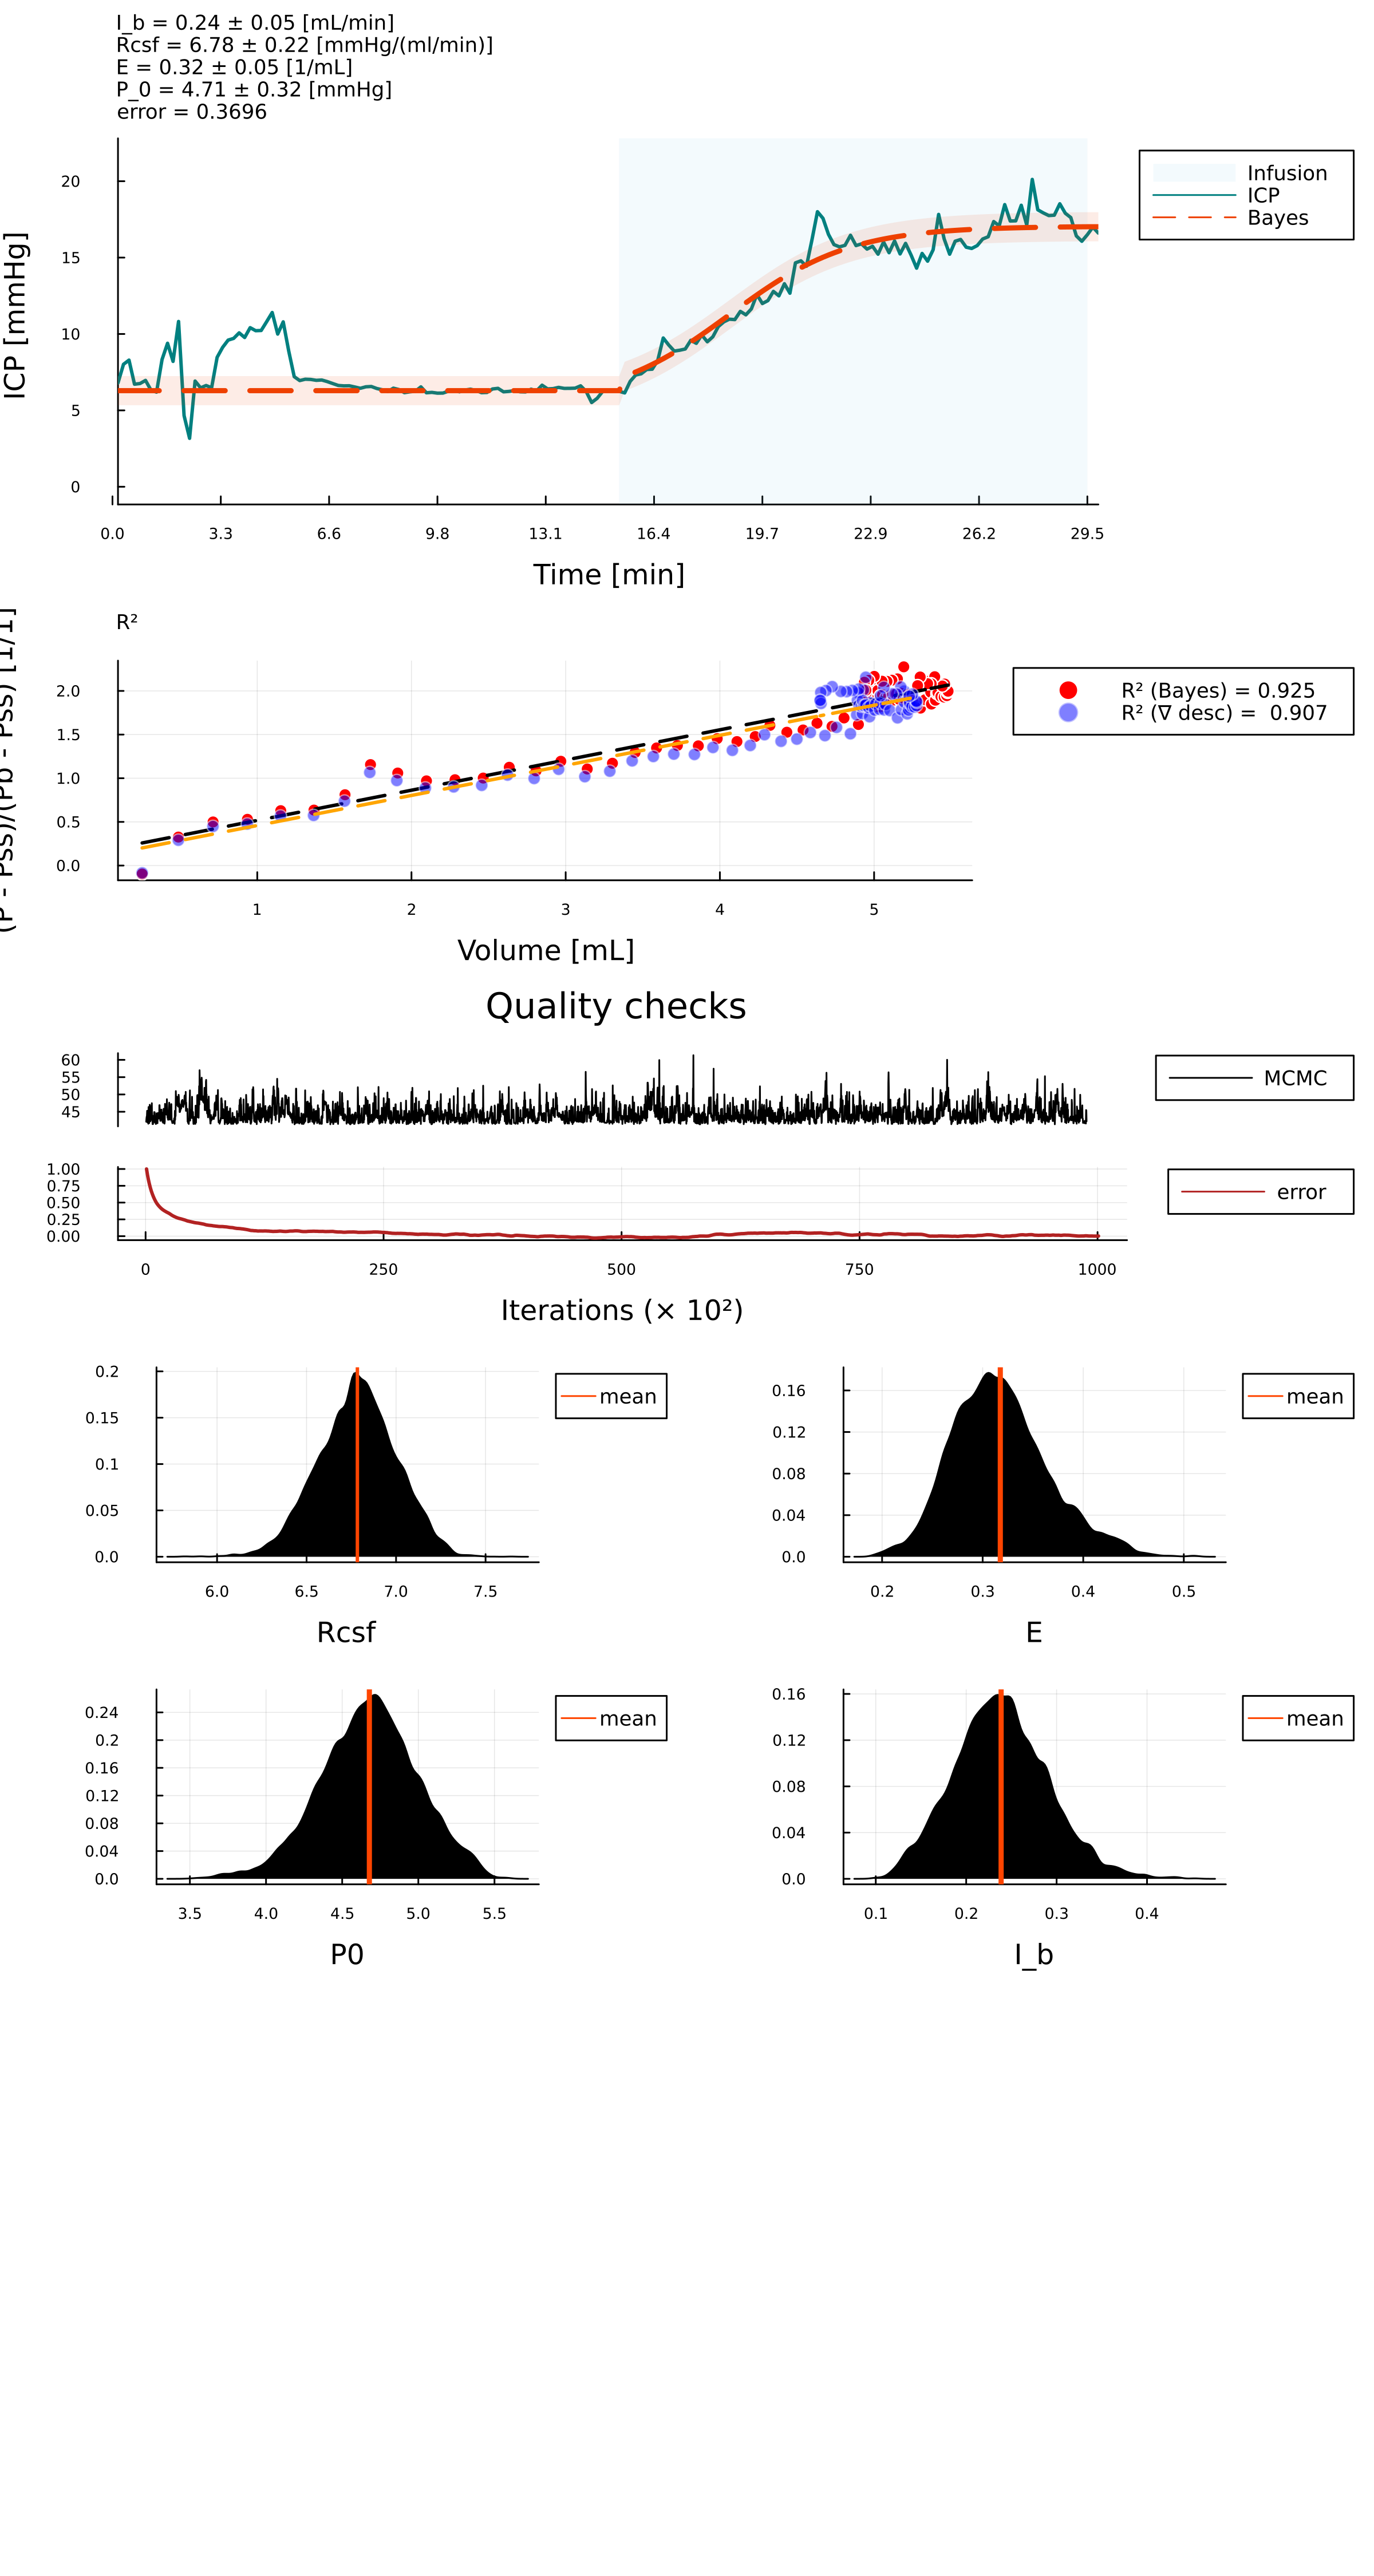

In [37]:
# Rcsf = mean(thetasave_t[1,:])
# plotmodel(mean(Ib_all), mean(thetasave_t[2,:]), mean(thetasave_t[3,:]), "dark", "")
using StatsPlots,Printf, LinearAlgebra
μ = mean(thetasave_t, dims=2)
σ = std(thetasave_t, dims=2)

Rcsf = sigmoid(mean(thetasave[1,:]), lb[1], ub[1])
E = sigmoid(mean(thetasave[2,:]), lb[2], ub[2])
P_0 = sigmoid(mean(thetasave[3,:]), lb[3], ub[3])
I_b = mean(Ib_all)
rmserr = calc_model_plot(I_b, E, P_0)[2]
h0 = plotmodel(I_b, E, P_0, μ, σ, "dar", "")
title!("I_b = $(@sprintf("%.2f", I_b)) ± $(@sprintf("%.2f",std(Ib_all))) [mL/min]\n" * "Rcsf = $(@sprintf("%.2f", Rcsf)) ± $(round(std(thetasave_t[1,:]),digits=2)) [mmHg/(ml/min)]\n" * "E = $(round(value(E),digits=2)) ± $(round(std(thetasave_t[2,:]),digits=2)) [1/mL]\n" * "P_0 = $(round(value(P_0),digits=2)) ± $(round(std(thetasave_t[3,:]),digits=2)) [mmHg]\n" * "error = $rmserr", titlealign=:left, titlefontsize=8, xlabel="Time [min]", ylabel="\n ICP [mmHg]")

# Plot ICM+ curve
# icmp_curve = calc_model_plot((Data["P_b"]-Data["P_0"])/Data["Rcsf"], Data["E"], Data["P_0"])[1]
# plot!(icmp_curve, lw=2, alpha=0.7, label="∇ descent")

# CSV.write("/Users/jjc/CSF/Results/Results_BayesSTD.csv", df)

R_bayes = Rcsf
R_icm = Data["Rcsf"]
P0_bayes = P_0
P0_icm = Data["P_0"]
nr=1

bayescol=:red
icmcol=:blue
bgcolor=:white

volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(R_bayes[nr], P0_bayes[nr])

h00 = plot(volRes, log.(pressRes), seriestype=:scatter, makersize=5, color=bayescol, markerstrokewidth=0.5, markerstrokecolor=bgcolor, linewidth=1, label= @sprintf("R² (Bayes) = %.3f", R2), grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]")
plot!(volRes, fitted_curve, lw=2, linecolor=:black, linestyle=:dash, legend=:outertopright, label="")

volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(R_icm[nr], P0_icm[nr])
plot!(volRes, log.(pressRes), seriestype=:scatter, alpha=0.5, makersize=5, color=icmcol, markerstrokewidth=0.5, markerstrokecolor=bgcolor, linewidth=1, 
label="$(@sprintf("R² (∇ desc) =  %.3f", R2))", grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]")
plot!(volRes, fitted_curve, lw=2, linecolor=:orange, linestyle=:dash, legend=:outertopright, label="")
title!("R²")

opt_idx = findmin(chisave)[2]

h1 = plot(chisave[1:10:end], linecolor=:black, label="MCMC", xaxis=false, xticks=[], title="Quality checks", grid=false,legend=:outertopright)

acf = autocor(chisave, collect(0:1000), demean=true)

h2 = plot(acf,label="error", xlabel="Iterations (× 10²)", lw=2, linecolor=:firebrick,legend=:outertopright)

h3 = density(thetasave_t[1,:],label="", fillrange=0, color=:black, legend=:outertopright)
# b= plotattr(:Series,"nbins")
ytk = parse.(Float64, yticks(h3)[1][2])
hist_fit = Distributions.fit(Histogram, thetasave_t[1,:])
hist_fit = LinearAlgebra.normalize(hist_fit, mode=:probability)
fac = sum(hist_fit.weights.*diff(hist_fit.edges[1]))
h03 = plot(hist_fit)
# ytk_norm = parse.(Float64, yticks(h03)[1][2])
vline!(h3, [mean(thetasave_t[1,:])],lw=2,label="mean", linecolor=:orangered, xlabel="Rcsf", yticks=(ytk, round.(ytk.*fac,digits=5)), ylabel="\n\n")
# vline!(h3, [thetasave_t[1,opt_idx]],lw=2,label="Max L(θ)", linecolor=:teal,legend=:outertopright)
# vspan!(h3, [mean(thetasave_t[1,:])-std(thetasave_t[1,:]),mean(thetasave_t[1,:])+std(thetasave_t[1,:])],lw=3,label="std", linecolor=:transparent, alpha=0.1, color=:orangered, xlims=[0,50])

h4 = density(thetasave_t[2,:],label="", fillrange=0, color=:black, legend=:outertopright)
ytk = parse.(Float64, yticks(h4)[1][2])
hist_fit = Distributions.fit(Histogram, thetasave_t[2,:])
hist_fit = LinearAlgebra.normalize(hist_fit, mode=:probability)
fac = sum(hist_fit.weights.*diff(hist_fit.edges[1]))
vline!(h4, [mean(thetasave_t[2,:])],lw=3,label="mean", linecolor=:orangered, xlabel="E", yticks=(ytk, round.(ytk.*fac,digits=5)), ylabel="\n\n")
# vline!(h4, [thetasave_t[2,opt_idx]],lw=2,label="Max L(θ)", linecolor=:teal,legend=:outertopright)
# vspan!(h4, [mean(thetasave_t[2,:])-std(thetasave_t[2,:]),mean(thetasave_t[2,:])+std(thetasave_t[2,:])],lw=3,label="std", linecolor=:transparent, alpha=0.1, color=:orangered)

h5 = density(thetasave_t[3,:],label="", fillrange=0, color=:black, legend=:outertopright)
ytk = parse.(Float64, yticks(h5)[1][2])
hist_fit = Distributions.fit(Histogram, thetasave_t[3,:])
hist_fit = LinearAlgebra.normalize(hist_fit, mode=:probability)
fac = sum(hist_fit.weights.*diff(hist_fit.edges[1]))
vline!(h5, [mean(thetasave_t[3,:])],lw=3,label="mean", linecolor=:orangered, xlabel="P0", yticks=(ytk, round.(ytk.*fac,digits=2)), ylabel="\n\n")
# vline!(h5, [thetasave_t[3,opt_idx]],lw=2,label="Max L(θ)", linecolor=:teal,legend=:outertopright)
# vspan!(h5, [mean(thetasave_t[3,:])-std(thetasave_t[3,:]),mean(thetasave_t[3,:])+std(thetasave_t[3,:])],lw=3,label="std", linecolor=:transparent, alpha=0.1, color=:orangered)

# h6 = histogram(Ib_all,nbins=100, label="", xlabel="I_f",color=:black)
h6 = density(Ib_all,label="", fillrange=0, color=:black, legend=:outertopright)
ytk = parse.(Float64, yticks(h6)[1][2])
hist_fit = Distributions.fit(Histogram, Ib_all)
hist_fit = LinearAlgebra.normalize(hist_fit, mode=:probability)
fac = sum(hist_fit.weights.*diff(hist_fit.edges[1]))
vline!(h6, [mean(Ib_all)],lw=3,label="mean", linecolor=:orangered, xlabel="I_b", yticks=(ytk, round.(ytk.*fac,digits=2)), ylabel="\n\n")
# vline!(h6, [Ib_all[opt_idx]],lw=2, label="Max L(θ)", linecolor=:teal,legend=:outertopright)
# vspan!(h6, [mean(Ib_all)-std(Ib_all),mean(Ib_all)+std(Ib_all)],lw=3,label="std", linecolor=:transparent, alpha=0.1, color=:orangered, xlims=[0,1])

plot(h0, h00, h1, h2, h3, h4, h5, h6, layout=[grid(4,1, heights=[.5,.3,.1,.1]),grid(2,2, heights=[.2, .2, .2, .2])], size=(800,1500), dpi=300, tickfontsize=6)


# savefig("qchecks1.png")


# ylims(h6)